In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction
In this notebook, I will implement Word2Vec on a Radiohead song. I chose *Let Down* because it is underrated /s.

In [92]:
song = """
Transport, motorways and tramlines
Starting and then stopping
Taking off and landing
The emptiest of feelings, disappointed people
Clinging onto bottles
When it comes, it's so, so disappointing
Let down and hanging around
Crushed like a bug in the ground
Let down and hanging around
Shell smashed, juices flowing
Wings twitch, legs are going
Don't get sentimental
It always ends up drivel
One day, I am gonna grow wings
A chemical reaction
Hysterical and useless
Hysterical and
Let down and hanging around
Crushed like a bug in the ground
Let down and hanging around
Let down again
Let down again
Let down again
You know, you know where you are with
You know where you are with
Floor collapses, floating
Bouncing back and
One day, I am gonna grow wings
A chemical reaction
Hysterical and useless
Hysterical and
Let down and hanging around
Crushed like a bug in the ground
Let down and hanging around
"""

# Tokenization

Unfortunately, you cannot do computations with letters. You need numbers. This begins by splitting up the text into smaller pieces, called tokens. I split them here

In [93]:
import re

def tokenize(text):
    content = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return list(set(content.findall(text.lower())))

song_tokens = tokenize(song)
len(song_tokens)

71

Hashmaps are beautiful structures that allow fast retrieval. We will now create a unique token_id to identify each token.

In [94]:
def mapping(tokens):

    word_to_id = {}
    id_to_word = {}
    for i in range(len(tokens)):
        word_to_id.update({tokens[i]: i})
        id_to_word.update({i: tokens[i]})
    return word_to_id,id_to_word

letdown_to_id, id_to_letdown = mapping(song_tokens)

In [95]:
letdown_to_id

{'hanging': 0,
 'transport': 1,
 'then': 2,
 'chemical': 3,
 'ground': 4,
 'disappointing': 5,
 'of': 6,
 'are': 7,
 'around': 8,
 'a': 9,
 'stopping': 10,
 'so': 11,
 'let': 12,
 'feelings': 13,
 'one': 14,
 'bouncing': 15,
 'hysterical': 16,
 'back': 17,
 'always': 18,
 'going': 19,
 'legs': 20,
 'with': 21,
 'day': 22,
 'flowing': 23,
 'up': 24,
 'clinging': 25,
 'and': 26,
 'juices': 27,
 'bottles': 28,
 'wings': 29,
 'like': 30,
 'landing': 31,
 'comes': 32,
 'taking': 33,
 'when': 34,
 'get': 35,
 'floor': 36,
 'know': 37,
 'off': 38,
 'shell': 39,
 'reaction': 40,
 'you': 41,
 'onto': 42,
 'people': 43,
 'emptiest': 44,
 'crushed': 45,
 'it': 46,
 'ends': 47,
 'again': 48,
 'sentimental': 49,
 'in': 50,
 'floating': 51,
 'down': 52,
 'motorways': 53,
 'starting': 54,
 "it's": 55,
 'useless': 56,
 'the': 57,
 'where': 58,
 'i': 59,
 'bug': 60,
 'drivel': 61,
 'gonna': 62,
 'grow': 63,
 'tramlines': 64,
 'collapses': 65,
 'twitch': 66,
 "don't": 67,
 'smashed': 68,
 'disappointed'

In [96]:
id_to_letdown

{0: 'hanging',
 1: 'transport',
 2: 'then',
 3: 'chemical',
 4: 'ground',
 5: 'disappointing',
 6: 'of',
 7: 'are',
 8: 'around',
 9: 'a',
 10: 'stopping',
 11: 'so',
 12: 'let',
 13: 'feelings',
 14: 'one',
 15: 'bouncing',
 16: 'hysterical',
 17: 'back',
 18: 'always',
 19: 'going',
 20: 'legs',
 21: 'with',
 22: 'day',
 23: 'flowing',
 24: 'up',
 25: 'clinging',
 26: 'and',
 27: 'juices',
 28: 'bottles',
 29: 'wings',
 30: 'like',
 31: 'landing',
 32: 'comes',
 33: 'taking',
 34: 'when',
 35: 'get',
 36: 'floor',
 37: 'know',
 38: 'off',
 39: 'shell',
 40: 'reaction',
 41: 'you',
 42: 'onto',
 43: 'people',
 44: 'emptiest',
 45: 'crushed',
 46: 'it',
 47: 'ends',
 48: 'again',
 49: 'sentimental',
 50: 'in',
 51: 'floating',
 52: 'down',
 53: 'motorways',
 54: 'starting',
 55: "it's",
 56: 'useless',
 57: 'the',
 58: 'where',
 59: 'i',
 60: 'bug',
 61: 'drivel',
 62: 'gonna',
 63: 'grow',
 64: 'tramlines',
 65: 'collapses',
 66: 'twitch',
 67: "don't",
 68: 'smashed',
 69: 'disappoin

With the text tokenized and lookup tables ready, we can now generate the training data in matrix form. Since tokens are still strings, we convert them to one-hot vectors. We also need to create input–target pairs, as word2vec is a supervised learning task.

The key question is: what are the inputs and targets? What are we predicting, and what do we feed the model? In word2vec, each word is an input, and the surrounding words (within a context window) are the targets.

This loop over each token, pairing it with nearby context words, is the core idea of word2vec. The figure below, from Ramzi Karam, illustrates this setup.
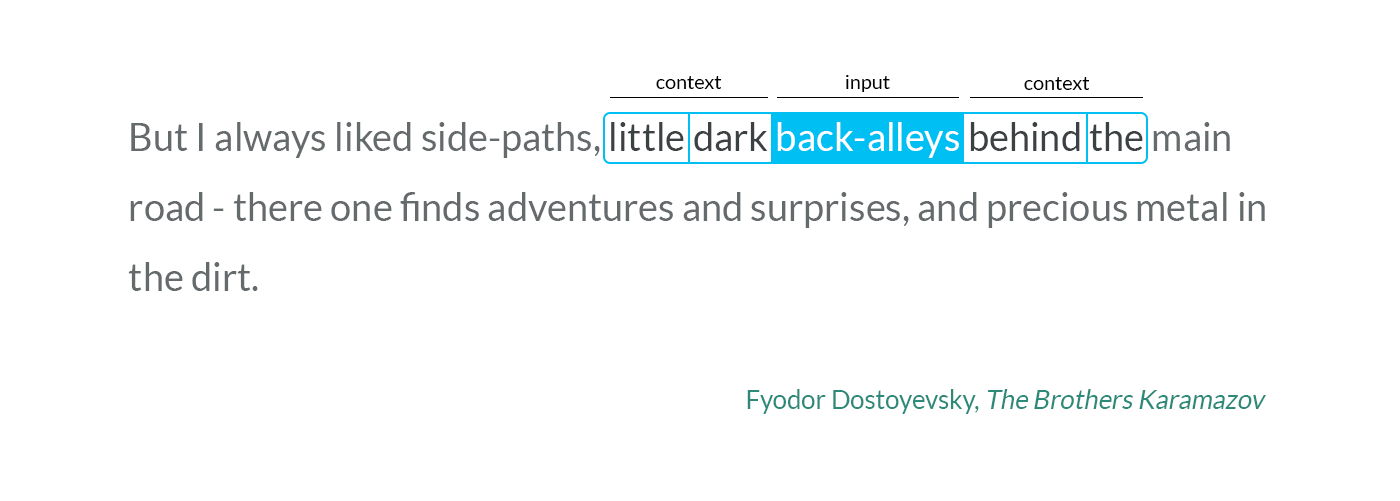

Since the window size is two, we look two to the left and two to the right of our word.
We would then generate these prediction pairs:
```
["back-alleys", "little"]
["back-alleys", "dark"]
["back-alleys", "behind"]
["back-alleys", "the"]
```

This allows our model to get a rough sense of context, and viewing words that occur together usually, like ['machine', 'learning'] or ['Thom', 'Yorke'], helps it establish some affinity between these words.

We will now generate input and output pairs. The edge cases are that at the beginning, we might not have enough words at the start and analogously at the end.

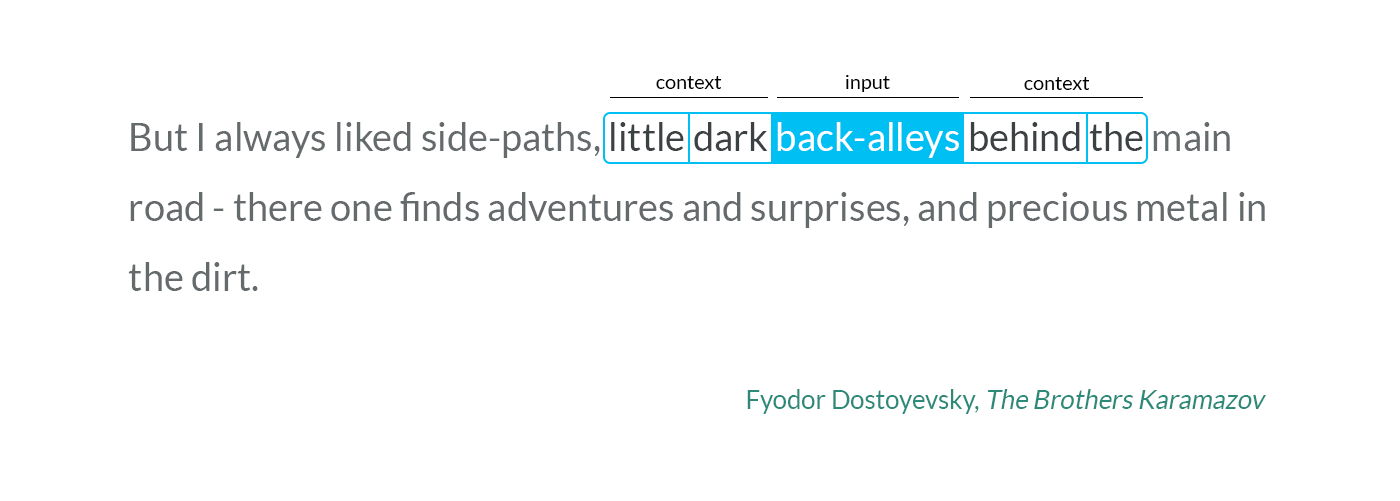

In [97]:
np.random.seed(42)
def one_hot_encode(id, vocab_size):
    vec = np.zeros(vocab_size, dtype=np.float32)
    vec[id] = 1.0
    return vec

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    num = len(tokens)

    for i in range(num):
        indices = concat(
            range(max(0, i - window), i),
            range(i + 1, min(num, i + window + 1))
        )
        for j in indices:
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))

    return np.asarray(X), np.asarray(y)

In [98]:
X, y = generate_training_data(song_tokens, letdown_to_id, 2)

In [99]:
X.shape, y.shape

((278, 71), (278, 71))

# The Embedding Model

In [100]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [101]:
model = init_network(len(letdown_to_id), 10)

# Forward Propogation

In [109]:
def softmax(X):
    exp = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return exp / exp.sum(axis=-1, keepdims=True)
    
def forward(model, X , return_cache = True):
    cache = {}
    cache['a1'] = X @ model['w1']
    cache['a2'] = cache['a1'] @ model['w2']
    cache['z'] = softmax(cache['a2'])
    if not return_cache:
        return cache["z"]
    return cache


In [110]:
(X @ model["w1"]).shape

(278, 10)

In [111]:
(X @ model["w1"] @ model["w2"]).shape

(278, 71)

# Backpropogation

In [112]:
def cross_entropy(z, y):
    eps = 1e-12
    return -np.mean(np.sum(y * np.log(z + eps), axis=1))

def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

# Testing the FFNN

/tmp/ipykernel_35/1289573071.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


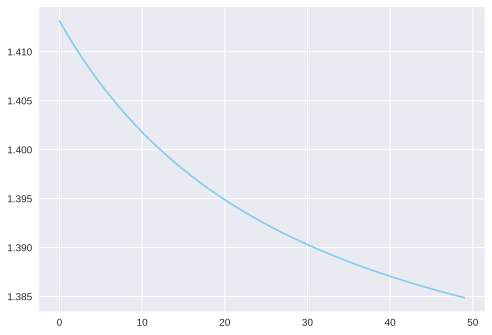

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

S

In [115]:
import numpy as np

# One-hot encode 'down'
idx = letdown_to_id["down"]
one_hot_vec = one_hot_encode(idx, len(letdown_to_id))  # shape: (vocab_size,)

# Reshape to 2D array for batch processing
input_vec = one_hot_vec.reshape(1, -1)  # shape: (1, vocab_size)

# Forward pass
result = forward(model, input_vec, return_cache=False)[0]  # shape: (vocab_size,)

# Print words sorted by predicted probability (highest first)
for idx in np.argsort(result)[::-1]:
    print(id_to_letdown[idx])

in
motorways
floating
starting
down
chemical
feelings
it's
again
sentimental
let
disappointed
hanging
stopping
bouncing
collapses
ends
one
floor
a
twitch
reaction
so
ground
smashed
of
shell
hysterical
am
useless
people
and
where
back
the
legs
up
are
juices
it
flowing
disappointing
transport
know
onto
then
gonna
get
around
off
grow
when
you
don't
going
i
day
like
landing
clinging
bug
crushed
emptiest
always
taking
comes
wings
drivel
tramlines
bottles
with


In [116]:
model["w1"]

array([[ 5.82650255e-01,  8.80518689e-01,  1.64201169e+00,
         1.49075762e-01, -5.65304028e-01, -1.15239705e+00,
         9.87010377e-01, -7.14367857e-01, -1.19010367e+00,
        -1.74612790e+00],
       [ 1.11010812e+00, -8.24872202e-02,  4.60045752e-01,
        -2.48095668e+00, -1.62614537e+00, -1.34097436e+00,
         7.31860434e-01,  1.99135622e-01, -4.85405043e-01,
        -2.08988072e+00],
       [ 1.41860772e+00,  8.29572325e-01, -5.85901328e-01,
        -1.18043073e+00, -1.73105713e+00, -1.48708511e+00,
        -2.52889764e-01, -1.26556309e+00, -1.40315087e+00,
        -9.51043155e-01],
       [ 1.45782003e-01,  2.56573154e+00,  2.23874161e-01,
        -8.41398461e-01,  2.31691686e-01, -1.10528541e+00,
         1.27387365e+00, -1.91595068e+00, -9.48516022e-01,
        -1.84096866e+00],
       [ 1.40838625e+00,  1.46147611e+00, -4.13649074e-01,
        -5.54008313e-01, -7.85650967e-01, -6.59072122e-01,
         7.69280774e-01,  8.41629709e-01,  1.81372628e-01,
        -2.

In [121]:
def get_embedding(model, word):
    try:
        idx = letdown_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, 71)
    return forward(model, one_hot)["a1"]

In [122]:
get_embedding(model, "down")

array([-0.27838448, -0.0923492 , -1.26372036, -1.82497946, -0.66643076,
       -0.3392123 , -2.45269073, -0.05931701,  1.24158194, -1.08052193])